In [1]:
# importing relevant packages 

import torch 
from torchvision import models
import pandas as pd
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import glob
import os
import cv2
import matplotlib.pyplot as plt 
from matplotlib import pyplot
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import json
from PIL import Image
import random
import albumentations as A
import glob
from shapely.geometry import Polygon

/home/dell/Desktop/xxxx/Uni/Kirigami_project/Keypoint_detection_notebooks/.Keypoint_detection_notebooks/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
class VGG_model(nn.Module):
    def __init__(self):
        super(VGG_model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.avgpool = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512,50, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d(output_size=(8,8))
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(3200, 300),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout(0.3),
            nn.Linear(300, 32),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        

In [3]:
model = VGG_model()
model.load_state_dict(torch.load('./Model_VGG_7_1000_22100_epoch'))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval()

VGG_model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.1, inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.1, inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.1, inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.1, inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.1, inplace=True)
    (14): Conv2d(

In [4]:
def predict_keypoints(img):
    img = cv2.resize(img, (224,224))
    img_tensor = transforms.ToTensor()(img)
    img_mean = img_tensor.mean(dim = (1,2))
    img_std = img_tensor.std(dim = (1,2))
        
    img_normalised = transforms.Normalize(img_mean, img_std)(img_tensor)
    img_normalised = img_normalised.to(device)
    
    key_points = model(img_normalised[None]).flatten().detach().cpu().numpy()
    
    return key_points

In [5]:
def plot_keypoints(img, keypoints):                                                             

    plt.imshow(img)

    x_points = keypoints[0::2]
    y_points = keypoints[1::2]
    plt.scatter(x_points*img.shape[1], y_points*img.shape[0], s = 4, c=(1,0,0))
    plt.show()

In [6]:
def process_num(x):
    return x*random.uniform(0.96, 1.04)

In [7]:
dataset_names = ['Grasp_dataset_banana', 'Grasp_dataset_chicken', 'Grasp_dataset_fig', 'Grasp_dataset_greengrape', 'Grasp_dataset_ibuprofen', 'Grasp_dataset_orange', 'Grasp_dataset_pear', 'Grasp_dataset_redgrape', 'Grasp_dataset_tomato']

header = ['weight_reading_1', 'weight_reading_2', 'pressure_reading_1', 'pressure_reading_2', 'force_reading_1', 'force_reading_2', 'p1_x', 'p1_y', 'p2_x', 'p2_y', 'p3_x', 'p3_y', 'p4_x', 'p4_y', 'p5_x', 'p5_y', 'p6_x', 'p6_y', 'p7_x', 'p7_y', 'p8_x', 'p8_y', 'p9_x', 'p9_y', 'p10_x', 'p10_y', 'p11_x', 'p11_y', 'p12_x', 'p12_y', 'p13_x', 'p13_y', 'p14_x', 'p14_y', 'p15_x', 'p15_y', 'p16_x', 'p16_y', 'label']

current_dir = os. getcwd()

weight_reading_1_arr = []
weight_reading_2_arr = []
pressure_reading_1_arr = []
pressure_reading_2_arr = []
force_reading_1_arr = []
force_reading_2_arr = []

p1_x_arr = []
p1_y_arr = []
p2_x_arr = []
p2_y_arr = []
p3_x_arr = []
p3_y_arr = []
p4_x_arr = []
p4_y_arr = []
p5_x_arr = []
p5_y_arr = []
p6_x_arr = []
p6_y_arr = []
p7_x_arr = []
p7_y_arr = []
p8_x_arr = []
p8_y_arr = []
p9_x_arr = []
p9_y_arr = []
p10_x_arr = []
p10_y_arr = []
p11_x_arr = []
p11_y_arr = []
p12_x_arr = []
p12_y_arr = []
p13_x_arr = []
p13_y_arr = []
p14_x_arr = []
p14_y_arr = []
p15_x_arr = []
p15_y_arr = []
p16_x_arr = []
p16_y_arr = []
label_arr = []


for f in dataset_names:
    
    image_dir = os.path.join(current_dir + '/Grasp_dataset_6', f)
#     image_dir = os.path.join(current_dir + '/Grasp_dataset_6_test', f)
    data_dir = os.path.join(image_dir, f + '.csv')
    df = pd.read_csv(data_dir)
    weight_reading_1_arr = np.concatenate((weight_reading_1_arr, df['weight_reading_1'].values))
    weight_reading_2_arr = np.concatenate((weight_reading_2_arr, df['weight_reading_2'].values))
    pressure_reading_1_arr = np.concatenate((pressure_reading_1_arr, df['pressure_reading_1'].values))
    pressure_reading_2_arr = np.concatenate((pressure_reading_2_arr, df['pressure_reading_2'].values))
    force_reading_1_arr = np.concatenate((force_reading_1_arr, df['force_reading_1'].values))
    force_reading_2_arr = np.concatenate((force_reading_2_arr, df['force_reading_2'].values))
    label_arr = np.concatenate((label_arr, df['label'].values))
    
    j = 0
    
    while j < df.shape[0]:
        image = cv2.imread(os.path.join(image_dir, df.iloc[j]['image_name']))
        keypoints = predict_keypoints(image)
        
#         plot_keypoints(image, keypoints)
        
#         if j == 20:
#             plot_keypoints(image, keypoints)
        

#         plt.imshow(image)

#         plt.scatter(kirigami_x_points*image.shape[1], kirigami_y_points*image.shape[0], s = 4, c=(1,0,0))
#         plt.show()
        
        p1_x_arr.append(keypoints[0])
        p1_y_arr.append(keypoints[1])
        p2_x_arr.append(keypoints[2])
        p2_y_arr.append(keypoints[3])
        p3_x_arr.append(keypoints[4])
        p3_y_arr.append(keypoints[5])
        p4_x_arr.append(keypoints[6])
        p4_y_arr.append(keypoints[7])
        p5_x_arr.append(keypoints[8])
        p5_y_arr.append(keypoints[9])
        p6_x_arr.append(keypoints[10])
        p6_y_arr.append(keypoints[11])
        p7_x_arr.append(keypoints[12])
        p7_y_arr.append(keypoints[13])
        p8_x_arr.append(keypoints[14])
        p8_y_arr.append(keypoints[15])
        p9_x_arr.append(keypoints[16])
        p9_y_arr.append(keypoints[17])
        p10_x_arr.append(keypoints[18])
        p10_y_arr.append(keypoints[19])
        p11_x_arr.append(keypoints[20])
        p11_y_arr.append(keypoints[21])
        p12_x_arr.append(keypoints[22])
        p12_y_arr.append(keypoints[23])
        p13_x_arr.append(keypoints[24])
        p13_y_arr.append(keypoints[25])
        p14_x_arr.append(keypoints[26])
        p14_y_arr.append(keypoints[27])
        p15_x_arr.append(keypoints[28])
        p15_y_arr.append(keypoints[29])
        p16_x_arr.append(keypoints[30])
        p16_y_arr.append(keypoints[31])
        
        j = j + 1
        
#         if j == 2:
#             break
#     break



p1_x_arr = np.array(p1_x_arr) - np.array(p1_x_arr)
p2_x_arr = np.array(p2_x_arr) - np.array(p1_x_arr)
p3_x_arr = np.array(p3_x_arr) - np.array(p1_x_arr)
p4_x_arr = np.array(p4_x_arr) - np.array(p1_x_arr)
p5_x_arr = np.array(p5_x_arr) - np.array(p1_x_arr)
p6_x_arr = np.array(p6_x_arr) - np.array(p1_x_arr)
p7_x_arr = np.array(p7_x_arr) - np.array(p1_x_arr)
p8_x_arr = np.array(p8_x_arr) - np.array(p1_x_arr)
p9_x_arr = np.array(p9_x_arr) - np.array(p1_x_arr)
p10_x_arr = np.array(p10_x_arr) - np.array(p1_x_arr)
p11_x_arr = np.array(p11_x_arr) - np.array(p1_x_arr)
p12_x_arr = np.array(p12_x_arr) - np.array(p1_x_arr)
p13_x_arr = np.array(p13_x_arr) - np.array(p1_x_arr)
p14_x_arr = np.array(p14_x_arr) - np.array(p1_x_arr)
p15_x_arr = np.array(p15_x_arr) - np.array(p1_x_arr)
p16_x_arr = np.array(p16_x_arr) - np.array(p1_x_arr)

p1_y_arr = np.array(p1_y_arr) - np.array(p1_y_arr)
p2_y_arr = np.array(p2_y_arr) - np.array(p1_y_arr)
p3_y_arr = np.array(p3_y_arr) - np.array(p1_y_arr)
p4_y_arr = np.array(p4_y_arr) - np.array(p1_y_arr)
p5_y_arr = np.array(p5_y_arr) - np.array(p1_y_arr)
p6_y_arr = np.array(p6_y_arr) - np.array(p1_y_arr)
p7_y_arr = np.array(p7_y_arr) - np.array(p1_y_arr)
p8_y_arr = np.array(p8_y_arr) - np.array(p1_y_arr)
p9_y_arr = np.array(p9_y_arr) - np.array(p1_y_arr)
p10_y_arr = np.array(p10_y_arr) - np.array(p1_y_arr)
p11_y_arr = np.array(p11_y_arr) - np.array(p1_y_arr)
p12_y_arr = np.array(p12_y_arr) - np.array(p1_y_arr)
p13_y_arr = np.array(p13_y_arr) - np.array(p1_y_arr)
p14_y_arr = np.array(p14_y_arr) - np.array(p1_y_arr)
p15_y_arr = np.array(p15_y_arr) - np.array(p1_y_arr)
p16_y_arr = np.array(p16_y_arr) - np.array(p1_y_arr)


weight_diff_1_arr = np.array(weight_reading_1_arr) - np.array(force_reading_1_arr)
weight_diff_2_arr = np.array(force_reading_2_arr) - np.array(weight_reading_2_arr) 

grasp_dataset = pd.concat([pd.Series(weight_diff_1_arr), pd.Series(weight_diff_2_arr), pd.Series(pressure_reading_1_arr), pd.Series(pressure_reading_2_arr), pd.Series(force_reading_1_arr), pd.Series(force_reading_2_arr), pd.Series(p1_x_arr), pd.Series(p1_y_arr), pd.Series(p2_x_arr), pd.Series(p2_y_arr), pd.Series(p3_x_arr), pd.Series(p3_y_arr), pd.Series(p4_x_arr), pd.Series(p4_y_arr), pd.Series(p5_x_arr), pd.Series(p5_y_arr), pd.Series(p6_x_arr), pd.Series(p6_y_arr), pd.Series(p7_x_arr), pd.Series(p7_y_arr), pd.Series(p8_x_arr), pd.Series(p8_y_arr), pd.Series(p9_x_arr), pd.Series(p9_y_arr), pd.Series(p10_x_arr), pd.Series(p10_y_arr), pd.Series(p11_x_arr), pd.Series(p11_y_arr), pd.Series(p12_x_arr), pd.Series(p12_y_arr), pd.Series(p13_x_arr), pd.Series(p13_y_arr), pd.Series(p14_x_arr), pd.Series(p14_y_arr), pd.Series(p15_x_arr), pd.Series(p15_y_arr), pd.Series(p16_x_arr), pd.Series(p16_y_arr), pd.Series(label_arr)], axis=1, keys=header)

# num_cols = grasp_dataset.select_dtypes(include=['float']).columns
# df[num_cols] = grasp_dataset[num_cols].applymap(process_num)

# combined_df_set = grasp_dataset
# combined_df_set = pd.concat([combined_df_set, grasp_dataset], axis=0)


In [8]:
pd.options.display.max_columns = None
print(grasp_dataset.head(3))

   weight_reading_1  weight_reading_2  pressure_reading_1  pressure_reading_2  \
0             135.3             110.1                49.0                40.2   
1             129.3             116.1                50.5                64.1   
2             135.9             109.2                30.5                36.9   

   force_reading_1  force_reading_2  p1_x  p1_y      p2_x      p2_y      p3_x  \
0            416.4            416.2   0.0   0.0  0.481372  0.124297  0.800877   
1            390.6            390.1   0.0   0.0  0.479384  0.131689  0.801309   
2            417.2            416.6   0.0   0.0  0.481168  0.112674  0.802835   

       p3_y      p4_x      p4_y      p5_x      p5_y      p6_x      p6_y  \
0  0.357011  0.799190  0.692748  0.478714  0.913016  0.178616  0.692796   
1  0.353154  0.800640  0.696747  0.476146  0.910528  0.179231  0.685205   
2  0.358925  0.799254  0.695613  0.476445  0.905608  0.178912  0.687778   

       p7_x      p7_y      p8_x      p8_y      p9

In [9]:
grasp_dataset

,weight_reading_1,weight_reading_2,pressure_reading_1,pressure_reading_2,force_reading_1,force_reading_2,p1_x,p1_y,p2_x,p2_y,p3_x,p3_y,p4_x,p4_y,p5_x,p5_y,p6_x,p6_y,p7_x,p7_y,p8_x,p8_y,p9_x,p9_y,p10_x,p10_y,p11_x,p11_y,p12_x,p12_y,p13_x,p13_y,p14_x,p14_y,p15_x,p15_y,p16_x,p16_y,label
0,135.3,110.1,49.0,40.2,416.4,416.2,0.0,0.0,0.481372,0.124297,0.800877,0.357011,0.799190,0.692748,0.478714,0.913016,0.178616,0.692796,0.465408,0.256493,0.455201,0.390977,0.452642,0.524924,0.459536,0.650407,0.467990,0.779443,0.499247,0.779649,0.515562,0.648186,0.522059,0.519496,0.514061,0.396930,0.500716,0.261830,banana
1,129.3,116.1,50.5,64.1,390.6,390.1,0.0,0.0,0.479384,0.131689,0.801309,0.353154,0.800640,0.696747,0.476146,0.910528,0.179231,0.685205,0.466438,0.256791,0.457492,0.390625,0.455398,0.525406,0.461799,0.652198,0.468772,0.781015,0.498244,0.780673,0.515334,0.649427,0.521879,0.520392,0.513697,0.398358,0.499506,0.263677,banana
2,135.9,109.2,30.5,36.9,417.2,416.6,0.0,0.0,0.481168,0.112674,0.802835,0.358925,0.799254,0.695613,0.476445,0.905608,0.178912,0.687778,0.464334,0.249908,0.454964,0.385733,0.452365,0.520139,0.459099,0.645314,0.466819,0.773503,0.497965,0.773879,0.515554,0.643498,0.522940,0.515132,0.514853,0.391955,0.501170,0.255019,banana
3,135.5,110.8,25.5,70.1,417.0,416.9,0.0,0.0,0.479516,0.127339,0.803100,0.345639,0.796231,0.678933,0.480904,0.915693,0.177847,0.697913,0.465464,0.255302,0.454442,0.390082,0.452136,0.525146,0.458532,0.651830,0.467714,0.781138,0.498102,0.779260,0.513604,0.646606,0.520656,0.517742,0.513482,0.395069,0.500232,0.259637,banana
4,136.4,109.6,27.1,73.9,413.9,413.9,0.0,0.0,0.479890,0.130002,0.804149,0.345260,0.797110,0.678705,0.481413,0.917174,0.176391,0.699290,0.465605,0.257610,0.454636,0.392198,0.451906,0.527104,0.458145,0.653857,0.467445,0.783517,0.498730,0.780659,0.513729,0.647892,0.520833,0.518810,0.513911,0.395729,0.500808,0.260392,banana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,109.6,87.5,25.6,53.0,396.3,395.3,0.0,0.0,0.471555,0.116984,0.804426,0.329161,0.797798,0.721521,0.468620,0.907656,0.185157,0.678451,0.464346,0.250650,0.460345,0.387822,0.459339,0.524896,0.464569,0.652983,0.467722,0.779621,0.496956,0.775862,0.518303,0.645900,0.527110,0.518541,0.518402,0.396902,0.500918,0.257579,tomato
176,107.3,91.2,127.4,135.4,459.7,459.4,0.0,0.0,0.479128,0.103822,0.801320,0.359126,0.794491,0.686327,0.478850,0.918697,0.173579,0.694892,0.460920,0.251335,0.450965,0.390250,0.448357,0.526041,0.455418,0.653715,0.465040,0.782224,0.498026,0.778244,0.515132,0.646485,0.523108,0.518939,0.515508,0.397075,0.502490,0.256779,tomato
177,105.8,92.3,105.7,115.3,447.2,446.8,0.0,0.0,0.478617,0.103117,0.802707,0.358273,0.796420,0.704071,0.471714,0.916535,0.178596,0.680502,0.462946,0.247463,0.454710,0.386183,0.452648,0.522970,0.459148,0.651242,0.465188,0.779258,0.496432,0.776312,0.516324,0.645170,0.525327,0.518127,0.517129,0.397025,0.502641,0.256308,tomato
178,110.9,86.8,33.3,50.8,380.8,380.2,0.0,0.0,0.475955,0.127173,0.801962,0.354256,0.797581,0.715892,0.472214,0.909380,0.182694,0.682228,0.465048,0.254328,0.458899,0.390491,0.457535,0.527331,0.463244,0.655666,0.468101,0.783063,0.497431,0.780923,0.516835,0.651207,0.524617,0.523049,0.516166,0.400809,0.500404,0.262514,tomato


In [ ]:
# grasp_dataset.to_csv('/home/dell/Desktop/xxxx/Uni/Kirigami_project/Keypoint_detection_notebooks/Grasp_dataset_3/' + 'validation_df.csv', index=False)

In [10]:
# grasp_data = grasp_dataset.drop(columns=['label', 'weight_reading_1', 'weight_reading_2'], axis=1)
grasp_data = grasp_dataset.drop(columns=['label'], axis=1)
# grasp_data = grasp_dataset.drop(columns=['label', 'p1_x', 'p1_y', 'p2_x', 'p2_y', 'p3_x', 'p3_y', 'p4_x', 'p4_y', 'p5_x', 'p5_y', 'p6_x', 'p6_y', 'p7_x', 'p7_y', 'p8_x', 'p8_y', 'p9_x', 'p9_y', 'p10_x', 'p10_y', 'p11_x', 'p11_y', 'p12_x', 'p12_y', 'p13_x', 'p13_y', 'p14_x', 'p14_y', 'p15_x', 'p15_y', 'p16_x', 'p16_y'], axis=1)
grasp_data['weight_reading_1'] = grasp_data['weight_reading_1'] / 1000
grasp_data['weight_reading_2'] = grasp_data['weight_reading_2'] / 1000
grasp_data['pressure_reading_1'] = grasp_data['pressure_reading_1'] / 100
grasp_data['pressure_reading_2'] = grasp_data['pressure_reading_2'] / 100
grasp_data['force_reading_1'] = grasp_data['force_reading_1'] / 1000
grasp_data['force_reading_2'] = grasp_data['force_reading_2'] / 1000
grasp_label = grasp_dataset['label']

print(grasp_data.head(2))
print(grasp_label.head(2))

   weight_reading_1  weight_reading_2  pressure_reading_1  pressure_reading_2  \
0            0.1353            0.1101               0.490               0.402   
1            0.1293            0.1161               0.505               0.641   

   force_reading_1  force_reading_2  p1_x  p1_y      p2_x      p2_y      p3_x  \
0           0.4164           0.4162   0.0   0.0  0.481372  0.124297  0.800877   
1           0.3906           0.3901   0.0   0.0  0.479384  0.131689  0.801309   

       p3_y     p4_x      p4_y      p5_x      p5_y      p6_x      p6_y  \
0  0.357011  0.79919  0.692748  0.478714  0.913016  0.178616  0.692796   
1  0.353154  0.80064  0.696747  0.476146  0.910528  0.179231  0.685205   

       p7_x      p7_y      p8_x      p8_y      p9_x      p9_y     p10_x  \
0  0.465408  0.256493  0.455201  0.390977  0.452642  0.524924  0.459536   
1  0.466438  0.256791  0.457492  0.390625  0.455398  0.525406  0.461799   

      p10_y     p11_x     p11_y     p12_x     p12_y     p13_x  

Accuracy: 0.9722222222222222
weight_reading_1, 0.08479885116176399
weight_reading_2, 0.08443539764224392
pressure_reading_1, 0.03966370610780365
pressure_reading_2, 0.025501978895342056
force_reading_1, 0.09354941071288411
force_reading_2, 0.09866096604078589
p1_x, 0.0
p1_y, 0.0
p2_x, 0.01860391721440041
p2_y, 0.04498421751686837
p3_x, 0.016855986913876624
p3_y, 0.004168440345626565
p4_x, 0.005510408371686949
p4_y, 0.003781166773357654
p5_x, 0.005857939712994943
p5_y, 0.03995203443404738
p6_x, 0.011336211188243156
p6_y, 0.0064723809155523785
p7_x, 0.04941354161985433
p7_y, 0.0102589264518668
p8_x, 0.03243568571309782
p8_y, 0.007148437782452732
p9_x, 0.042124806462085294
p9_y, 0.006807726383141375
p10_x, 0.047341859130482854
p10_y, 0.010133626873875277
p11_x, 0.037625494862322986
p11_y, 0.0074418379931726515
p12_x, 0.013553863020653492
p12_y, 0.0069202691419505994
p13_x, 0.039763860459208836
p13_y, 0.0123245271391029
p14_x, 0.032315794775408184
p14_y, 0.009676095578774338
p15_x, 0.02066

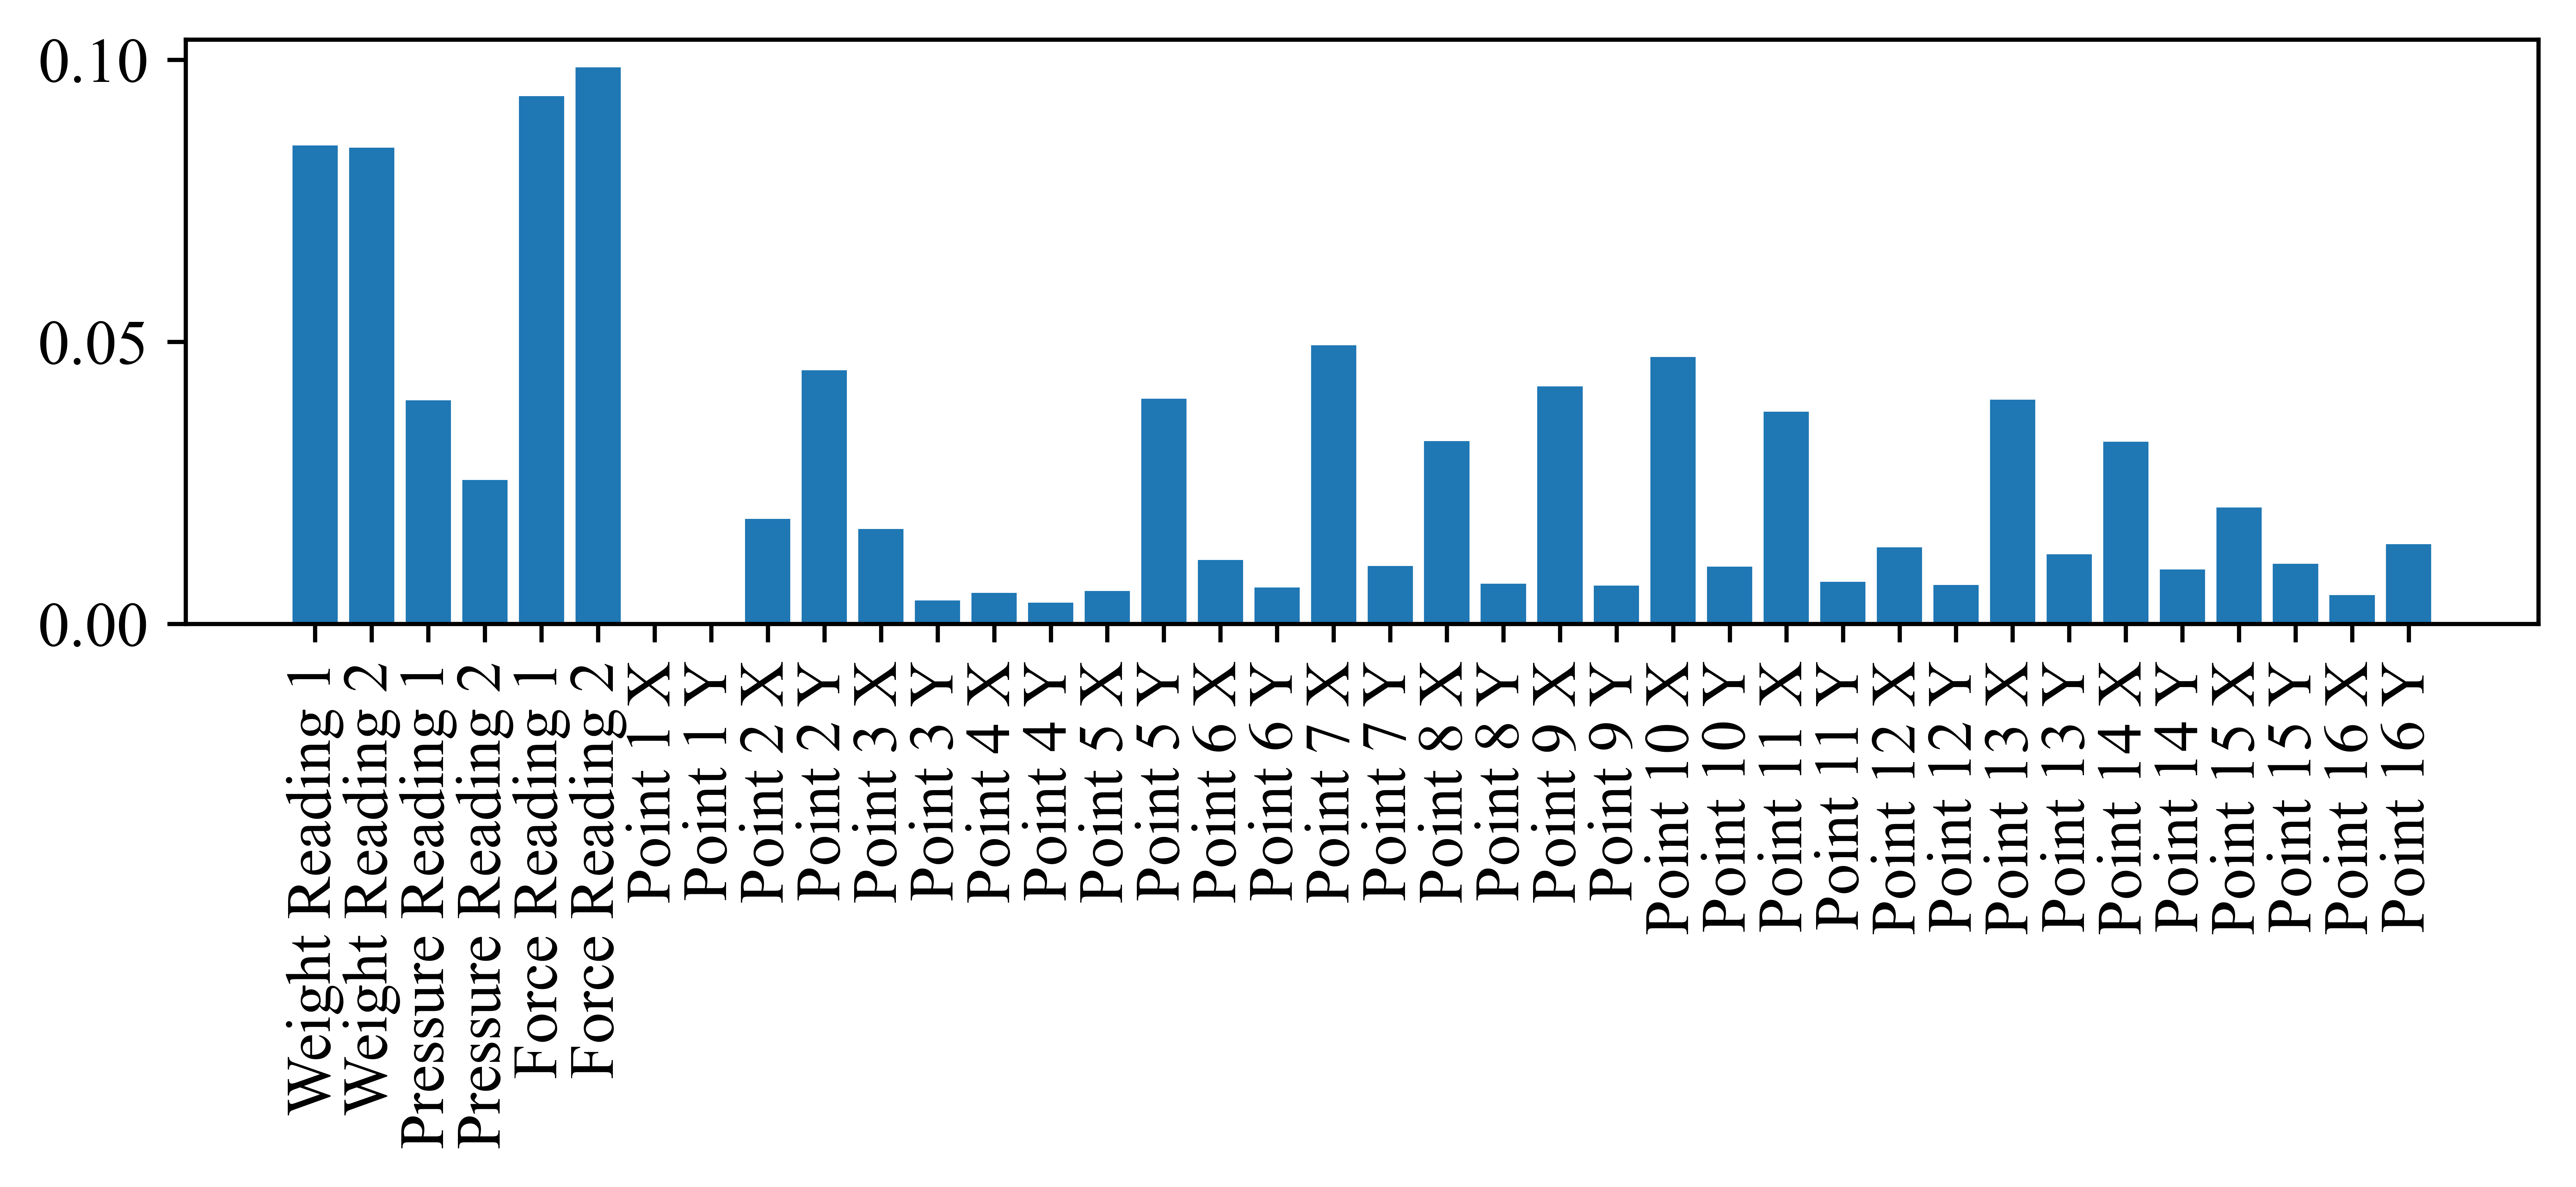

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

data_train, data_test, label_train, label_test = train_test_split(grasp_data, grasp_label, test_size=0.2, random_state=np.random.randint(100))

# print(X_train.head(3))

# clf = KNeighborsClassifier(n_neighbors=7)

# knn.fit(X_train, y_train)

# y_pred = knn.predict(X_test)

# accuracy = knn.score(X_test, y_test)
# print('Accuracy:', accuracy)
# clf = RandomForestClassifier(n_estimators=1000, max_depth=50, random_state=np.random.randint(100))
clf = RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=np.random.randint(100), n_jobs = -1)
# clf = HistGradientBoostingClassifier(max_iter=200, random_state=np.random.randint(100))
# clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=1, random_state=0)
# clf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],voting='hard')

# num_folds = 10
# cv_method = KFold(n_splits=num_folds, shuffle=True, random_state=np.random.randint(100))
# cv_results = cross_val_score(clf, grasp_data, grasp_label, cv=cv_method, scoring='accuracy')

# print('Cross-validation results:', cv_results)
# print('Average accuracy:', cv_results.mean())

clf.fit(data_train, label_train)
label_pred = clf.predict(data_test)
cm = confusion_matrix(label_test, label_pred)

# short_dataset_names = ['chicken', 'tomato']


# cm_df = pd.DataFrame(cm, index=short_dataset_names, columns=short_dataset_names)

# print(cm_df)
# print(cm)

accuracy = clf.score(data_test, label_test)
print("Accuracy:", accuracy)

importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print(f'{header[i]}, {v}')
#     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(8, 2), dpi=1200)
xlabel = ['Weight Reading 1', 'Weight Reading 2', 'Pressure Reading 1', 'Pressure Reading 2', 'Force Reading 1', 'Force Reading 2', 'Point 1 X', 'Point 1 Y', 'Point 2 X', 'Point 2 Y', 'Point 3 X', 'Point 3 Y', 'Point 4 X', 'Point 4 Y', 'Point 5 X', 'Point 5 Y', 'Point 6 X', 'Point 6 Y', 'Point 7 X', 'Point 7 Y', 'Point 8 X', 'Point 8 Y', 'Point 9 X', 'Point 9 Y', 'Point 10 X', 'Point 10 Y', 'Point 11 X', 'Point 11 Y', 'Point 12 X', 'Point 12 Y', 'Point 13 X', 'Point 13 Y', 'Point 14 X', 'Point 14 Y', 'Point 15 X', 'Point 15 Y', 'Point 16 X', 'Point 16 Y']
# plt.ylabel('Importance')
pyplot.bar(xlabel, importance)
pyplot.xticks(rotation=90)
pyplot.tick_params(axis='both', labelsize=12)
# plt.gca().invert_yaxis()
pyplot.show()

In [ ]:
label_pred = clf.predict(grasp_data)
print(label_pred)
accuracy = clf.score(grasp_data, grasp_label)
print("Accuracy:", accuracy)